In [1]:
# Standard imports:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Constants:

# Contains 1.6M samples
PATH_DATA = "../input/sentiment140/training.1600000.processed.noemoticon.csv"

# GloVe Twitter embeddings: 2B tweets, 27B tokens, 1.2M vocab, uncased,200-dimensional
PATH_EMB = "../input/glove-global-vectors-for-word-representation/glove.twitter.27B.200d.txt"
N_EMB = 200 # Dimensions of the embeddings

# Using fastText Word vectors trained on Wikipedia 2017, UMBC webbase corpus, and statmt.org
# PATH_EMB = "../input/fasttext-wikinews/wiki-news-300d-1M.vec"
# N_EMB = 300

# Number of samples to be taken
LIMIT = 1600000

# Fraction of samples to be used for training set
N_TRAIN = 0.9

# Size of each sequence to be embedded:
N_SEQ = 0 # Chosen later based on the histogram of the lengths

## Data reading and pre-processing

In [3]:
# Function that returns the processed dataframe
def loadDF(n_samples):
    
    # Read
    df = pd.read_csv(
        PATH_DATA, 
        encoding = "latin", # No encoding results in decode error 
        header = None
    )
    
    # Drop columns which aren't needed
    df.drop(labels = [1,2,3,4], axis = "columns", inplace = True)
    df.columns = ["Label", "Text"]
    
    # Relabel 0 -> 0 and 4 -> 1 (0:Negative, 1:Positive)
    df.replace(to_replace = 4, value = 1, inplace = True)
    
    # Training on 1.6M samples takes a lot of time, we train on a smaller randomized subset of the data
    df = df.sample(n = n_samples, random_state = 42)
    
    return df

In [4]:
df = loadDF(LIMIT)
print("Class distribution:\n{}".format(df["Label"].value_counts()))

Class distribution:
0    5004
1    4996
Name: Label, dtype: int64


## Cleaning the data:

In [5]:
# Check for null values
check = df.isnull().sum()
print(check)

Label    0
Text     0
dtype: int64


## WordCloud visualization:

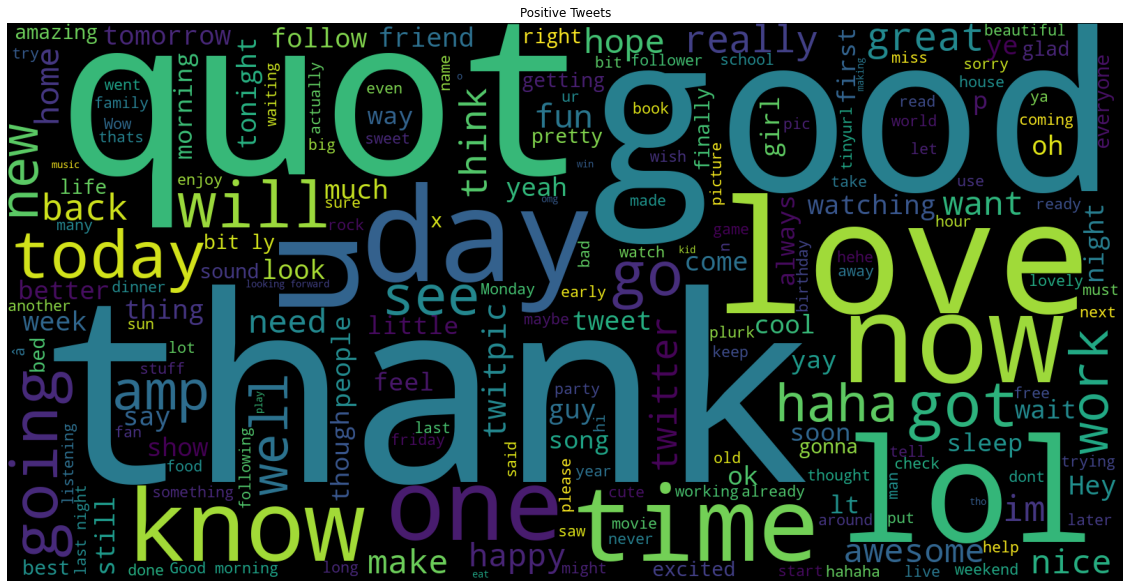

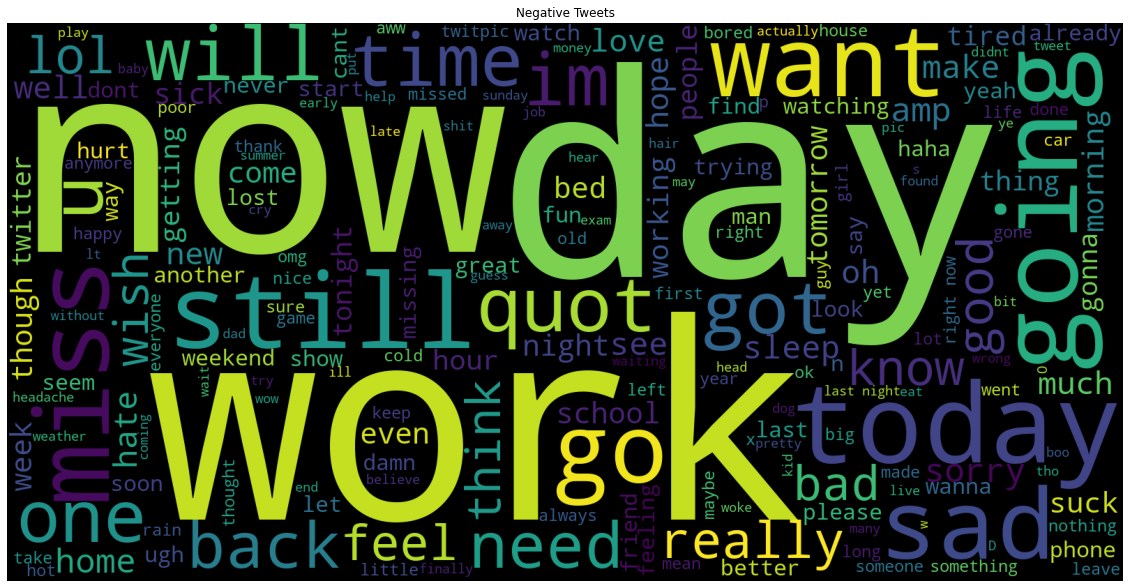

In [6]:
from wordcloud import WordCloud

df_pos = df.loc[df["Label"] == 1]
df_neg = df.loc[df["Label"] == 0]

wc_pos = WordCloud(
    width = 1600, 
    height = 800, 
).generate(" ".join(df_pos["Text"])) 

wc_neg = WordCloud(
    width = 1600, 
    height = 800, 
).generate(" ".join(df_neg["Text"])) 

plt.figure(figsize = (20,20))
plt.imshow(wc_pos)
plt.title("Positive Tweets")
plt.axis("off")
plt.show()

plt.figure(figsize = (20,20))
plt.imshow(wc_neg)
plt.title("Negative Tweets")
plt.axis("off")
plt.show()

In [7]:
# Add common words as stopwords
n_sw = 50 # Add n_sw of the top common words as stop words
top_pos = list(wc_pos.words_.keys()) # Sorted in decr order of frequencies, len=200
top_neg = list(wc_neg.words_.keys())
common = list(set(top_pos[:n_sw]) & set(top_neg[:n_sw]))
print(common)

['will', 'hope', 'well', 'oh', 'make', 'now', 'home', 'really', 'new', 'going', 'still', 'day', 'go', 'quot', 'know', 'u', 'back', 'think', 'work', 'im', 'one', 'tomorrow', 'lol', 'time', 'today', 'need', 'see', 'amp', 'night', 'want', 'come', 'good', 'love', 'got']


In [8]:
# Only select some, as others are meaningful
common = ["amp", "quot", "lol" "u"]

In [9]:
import re
import nltk
import string
from unidecode import unidecode
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, TweetTokenizer

puncs = string.punctuation
sw = stopwords.words("english") # Not used as it contains "don't" "not" "did't" which are "negative" and will change the meaning of the sentence
sb = SnowballStemmer(language = "english") # Better and faster than PorterStemmer
# https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove mentions (@username), all URLs, all hashtags.  (\S+ matches with everything that is not a whitespace)
    text = re.sub("@\S+|http\S+|#\S+", "", text)
    # Remove punctuations (Redundant step, handled later in Keras tokenizer)
    text.translate(str.maketrans('', '', puncs))
    # Strip off accents (convert to ascii)
    text = unidecode(text)
    # Tokenize
    tokenized_text = word_tokenize(text)
    # Don't stem as overlap with embeddings vocab is close to 0 
    # DON'T remove stop words as they carry imp info about the meaning of the sentence and non-alphanumeric tokens
    cleaned_tokens = [t for t in tokenized_text if t.isalnum() and t not in common]
    cleaned_string = " ".join(cleaned_tokens)
    return cleaned_string

In [10]:
from tqdm import tqdm
tqdm.pandas()

def cleanDF(df):
    df["Text"] = df["Text"].progress_apply(lambda x : preprocess(x))
    return df

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [11]:
# This takes a lot of time
df = cleanDF(df)
display(df)

100%|██████████| 10000/10000 [00:03<00:00, 2975.51it/s]


,Label,Text
541200,0,ahhh i hope your ok
750,0,cool i have no tweet apps for my razr 2
766711,0,i know just family drama its next time u hang ...
285055,0,school email wo open and i have geography stuf...
705995,0,upper airways problem
...,...,...
965972,1,my sister cheyenne birthday party is today it ...
1193436,1,you are so welcome
896390,1,seriously those gals were making me nervous pa...
544127,0,thanks now i want chicken and cheesecake not t...


## Analyze the length of the tweets:
This will help us select the `N_SEQ`

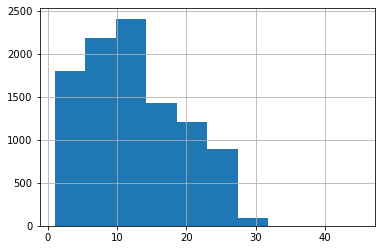

Mean: 12.4030
Std: 6.8302
Mean+3*Std = 32.8935


In [12]:
lengths = df["Text"].apply(lambda x : len(x.split(" "))) # try mean + 3*sigma
lengths.hist()
plt.show()

mean = lengths.mean()
std = lengths.std()
approx_nseq = mean + 3*std
print(f"Mean: {mean:.4f}\nStd: {std:.4f}\nMean+3*Std = {approx_nseq:.4f}")

Thus we keep `N_SEQ = 32` (Power of 2)

In [13]:
N_SEQ = 32

## Preparation before model training

In [14]:
from sklearn.model_selection import train_test_split as tts

# Split into training and validation sets
df_train, df_val = tts(df, train_size = N_TRAIN, shuffle = True, random_state = 42)

In [15]:
from keras.preprocessing.text import Tokenizer

def getTokenizer():
    tok = Tokenizer()
    # Create word_index and vocab
    tok.fit_on_texts(df_train["Text"])
    return tok

In [16]:
tok = getTokenizer()
word_index = tok.word_index
N_vocab = len(tok.word_index) + 1 # This +1 is used later 
print(N_vocab)

12385


In [17]:
from keras.preprocessing.sequence import pad_sequences

def getXY(tok):
    x_train = pad_sequences(tok.texts_to_sequences(df_train["Text"]), maxlen = N_SEQ, padding = "post")
    x_val   = pad_sequences(tok.texts_to_sequences(df_val["Text"]), maxlen = N_SEQ, padding = "post")
    y_train = df_train["Label"].to_numpy(dtype = float).reshape(-1, 1)
    y_val   = df_val["Label"].to_numpy(dtype = float).reshape(-1, 1)
    return x_train, x_val, y_train, y_val

In [18]:
x_train, x_val, y_train, y_val = getXY(tok)

## Preparing the Embedding layer
Reference: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [19]:
# Maps each word in the embeddings vocabulary to it's embedded representation 
embeddings_index = {}
with open(PATH_EMB, "r", errors="ignore") as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

1193514it [02:01, 9841.65it/s] 


In [20]:
# Maps each word in our vocab to it's embedded representation, if the word is present in the GloVe embeddings
embedding_matrix = np.zeros((N_vocab, N_EMB))
n_match = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        n_match += 1
        embedding_matrix[i] = embedding_vector
print(n_match)

10889


This means only some match with the Twitter GloVe embeddings (We can improve this)

## The Model:

In [21]:
# Model constants and hyperparameters:
LR = 0.001 # Default for Adam is 0.001
N_BATCH = 256
N_EPOCHS = 10
N_HEADS = 8
DIM_HIDDEN = 64 # Dimensionality of the hidden state h_t outputted by the LSTM
# Dimensionality of the weight matrices used while computing the attention, note that we divide this into n_head parts later
DIM_KEY = N_HEADS*64

### Multiheaded Self Attention:
**References:** 
  
- **Code:** [Text classification with Transformer](https://keras.io/examples/nlp/text_classification_with_transformer/)   
  
- **Theory:**  
    - [Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/)  
    - [Custom Attention layer](https://towardsdatascience.com/create-your-own-custom-attention-layer-understand-all-flavours-2201b5e8be9e)
    - [Subclassing layers in Keras](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)

In [22]:
from keras import Sequential, Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Layer, Input, Embedding, Conv1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, GlobalMaxPooling1D, Flatten
import tensorflow as tf # Only used for various tensor operations

# A more general and complete version of the layer defined in the linked keras example

class MultiHeadSelfAttention(Layer):
    """ This uses Bahadanau attention """
    
    def __init__(self, num_heads = 8, weights_dim = 64):
        """ Constructor: Initializes parameters of the Attention layer """
        
        # Initialize base class:
        super(MultiHeadSelfAttention, self).__init__()
        
        # Initialize parameters of the layer:
        self.num_heads = num_heads
        self.weights_dim = weights_dim
        
        if self.weights_dim % self.num_heads != 0:
            raise ValueError(f"Weights dimension = {weights_dim} should be divisible by number of heads = {num_heads} to ensure proper division into sub-matrices")
            
        # We use this to divide the Q,K,V matrices into num_heads submatrices, to compute multi-headed attention
        self.sub_matrix_dim = self.weights_dim // self.num_heads 
        
        """
            Note that all K,Q,V matrices and their respective weight matrices are initialized and computed as a whole
            This ensures somewhat of a parallel processing/vectorization
            After computing K,Q,V, we split these into num_heads submatrices for computing the different attentions
        """
        
        # Weight matrices for computing query, key and value (Note that we haven't defined an activation function anywhere)
        # Important: In keras units contain the shape of the output
        self.W_q = Dense(units = weights_dim) 
        self.W_k = Dense(units = weights_dim)
        self.W_v = Dense(units = weights_dim)
        
        
    def get_config(self):
        """ Required for saving/loading the model """
        config = super().get_config().copy()
        config.update({
            "num_heads" : self.num_heads,
            "weights_dim" : self.weights_dim
            # All args of __init__() must be included here
        })
        return config
    
    
    def build(self, input_shape):
        """ Initializes various weights dynamically based on input_shape """
        input_dim = input_shape[-1]
        self.input_dim = input_dim
        # Weight matrix for combining the output from multiple heads:
        # Takes in input of shape (batch_size, seq_len, weights_dim) returns output of shape (batch_size, seq_len, input_dim)
        self.W_h = Dense(units = input_dim)

        
    def attention(self, query, key, value):
        """ The main logic """
        # Compute the raw score = QK^T 
        score = tf.matmul(query, key, transpose_b=True)
        
        # Scale by dimension of K
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) # == DIM_KEY
        scaled_score = score / tf.math.sqrt(dim_key)
        
        # Weights are the softmax of scaled scores
        weights = tf.nn.softmax(scaled_score, axis=-1)
        
        # The final output of the attention layer (weighted sum of hidden states)
        output = tf.matmul(weights, value)
        
        return output, weights

    
    def separate_heads(self, x, batch_size):
        """ 
            Splits the given x into num_heads submatrices and returns the result as a concatenation of these sub-matrices
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.sub_matrix_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    
    def call(self, inputs):
        """ All computations take place here """
        
        batch_size = tf.shape(inputs)[0]
        
        # Compute Q = W_q*X
        query = self.W_q(inputs)  # (batch_size, seq_len, weights_dim)
        
        # Compute K = W_k*X
        key = self.W_k(inputs)  # (batch_size, seq_len, weights_dim)
        
        # Compute V = W_v*X
        value = self.W_v(inputs)  # (batch_size, seq_len, weights_dim)
        
        # Split into n_heads submatrices
        query = self.separate_heads(query, batch_size)  # (batch_size, num_heads, seq_len, sub_matrix_dim)
        key = self.separate_heads(key, batch_size)  # (batch_size, num_heads, seq_len, sub_matrix_dim)
        value = self.separate_heads(value, batch_size) # (batch_size, num_heads, seq_len, sub_matrix_dim)
        
        # Compute attention (contains weights and attentions for all heads):
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, sub_matrix_dim)
        
        # Concatenate all attentions from different heads (squeeze the last dimension):
        concat_attention = tf.reshape(attention, (batch_size, -1, self.weights_dim))  # (batch_size, seq_len, weights_dim)
        
        # Use a weighted average of the attentions from different heads:
        output = self.W_h(concat_attention)  # (batch_size, seq_len, input_dim)
        
        return output
    
    
    def compute_output_shape(self, input_shape):
        print(input_shape)
        """ Specifies the output shape of the custom layer, without this, the model doesn't work """
        return input_shape

In [23]:
def buildModel1():
    
    # The input as sequences:
    input_layer = Input(shape=(N_SEQ,))
    # Create the embedding layer
    embedding_layer = Embedding(
        N_vocab,
        N_EMB,
        weights = [embedding_matrix],
        input_length = N_SEQ,
        trainable = False # No need to train as our embeddings are already finetuned on Twitter data
    )
    # Create the embeddings
    embedded_sequences = embedding_layer(input_layer)
    
    # The core of the model:
    
    # Single layer BiLSTM architecture
    x = Bidirectional(
        LSTM(
            units = DIM_HIDDEN, # In Keras, "units" mean the dimensionality of the hidden states h_t output by the LSTM 
            dropout = 0.2,
            # recurrent_dropout = 0.2, # Can't use the GPU if this is included 
            return_sequences = True
        ),
        merge_mode = "concat" # Just like in Transformers, thus output h = [h_f; h_b] will have dimension 2*DIM_HIDDEN
    )(embedded_sequences) 
        
    # Adding multiheaded self attention
    x = MultiHeadSelfAttention(N_HEADS, DIM_KEY)(x)
    
    outputs = Flatten()(x)
    
    model = Model(input_layer, outputs)
    return model

In [24]:
def buildModel2():
    input_layer = Input(shape = (2*N_SEQ*DIM_HIDDEN,))
    # Fully connected classifer
    x = Dense(1024, activation = "relu")(input_layer)
    x = Dropout(0.2)(x)
    x = Dense(256, activation = "relu")(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation = "relu")(x)
    outputs = Dense(1, activation = "sigmoid")(x)
    model = Model(input_layer, outputs)
    return model

In [25]:
def combineModels():
    model1 = buildModel1()
    model2 = buildModel2()
    
    input1 = Input(shape=(N_SEQ,))
    out1 = model1(input1)
    out2 = model2(out1)
    
    model = Model(input1, out2)
    return model

In [26]:
#model = buildModel()
model = combineModels()
model.compile(
    optimizer = Adam(learning_rate = LR), 
    loss = "binary_crossentropy", # As binary classification
    metrics = ["accuracy"] # Balanced classes, thus good enough metric
)

callbacks_list = [
    
    ModelCheckpoint(filepath = "model_{epoch:02d}_{val_accuracy:.2f}.h5"),

]

print(model.summary())

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
functional_1 (Functional)    (None, None)              2876488   
_________________________________________________________________
functional_3 (Functional)    (None, 1)                 4465985   
Total params: 7,342,473
Trainable params: 4,865,473
Non-trainable params: 2,477,000
_________________________________________________________________
None


## Training:

In [27]:
history = model.fit(
    x_train, 
    y_train, 
    batch_size = N_BATCH, 
    epochs = N_EPOCHS,
    validation_data = (x_val, y_val), 
    callbacks = callbacks_list
)

Epoch 1/10
36/36 [==============================] - 2s 51ms/step - loss: 0.6317 - accuracy: 0.6364 - val_loss: 0.5629 - val_accuracy: 0.7030
Epoch 2/10
36/36 [==============================] - 1s 21ms/step - loss: 0.5241 - accuracy: 0.7421 - val_loss: 0.5303 - val_accuracy: 0.7240
Epoch 3/10
36/36 [==============================] - 1s 21ms/step - loss: 0.5087 - accuracy: 0.7503 - val_loss: 0.5242 - val_accuracy: 0.7340
Epoch 4/10
36/36 [==============================] - 1s 24ms/step - loss: 0.4827 - accuracy: 0.7673 - val_loss: 0.5541 - val_accuracy: 0.7010
Epoch 5/10
36/36 [==============================] - 1s 22ms/step - loss: 0.4914 - accuracy: 0.7579 - val_loss: 0.5157 - val_accuracy: 0.7360
Epoch 6/10
36/36 [==============================] - 1s 21ms/step - loss: 0.4658 - accuracy: 0.7741 - val_loss: 0.5417 - val_accuracy: 0.7280
Epoch 7/10
36/36 [==============================] - 1s 21ms/step - loss: 0.4598 - accuracy: 0.7787 - val_loss: 0.5270 - val_accuracy: 0.7440
Epoch 8/10
36

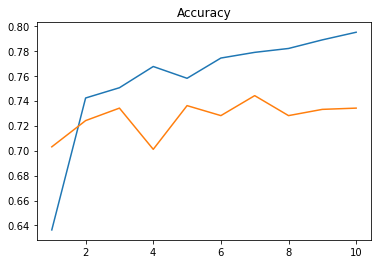

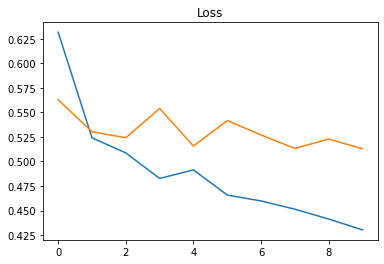

In [28]:
metrics = history.history
t_acc = metrics["accuracy"]
t_loss = metrics["loss"]
v_acc = metrics["val_accuracy"]
v_loss = metrics["val_loss"]

epochs = range(1, N_EPOCHS + 1)

plt.plot(epochs, t_acc)
plt.plot(epochs, v_acc)
plt.title("Accuracy")

plt.figure()
plt.plot(t_loss)
plt.plot(v_loss)
plt.title("Loss")

plt.show()

Going by the plots, training for more epochs and on more data and choosing the proper hyperparameters can increase the accuracy even more.